### **CC57 - MACHINE LEARNING - CLASIFICADOR NAIVE BAYES - MULTINOMIAL**

Nos centraremos principalmente en una tarea de clasificación de texto popular: filtrado de spam, utilizando Multinomial Naive Bayes.

El dataset consta de 5573 observaciones en 2 variables, 1 predictiva (text) y una objetivo (target).

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
data = pd.read_csv("SMSSpamCollection.csv")

In [44]:
data.head()

,target,text
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [45]:
#Principales estadisticas
data.describe()

,target,text
count,5573,5573
unique,2,5170
top,ham,"Sorry, I'll call later"
freq,4826,30


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5573 non-null   object
 1   text    5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [47]:
data.shape

(5573, 2)

In [48]:
data['objetivo'] = np.where(data['target']=='ham',0, 1)

In [49]:
data.head()

,target,text,objetivo
0,ham,Ok lar... Joking wif u oni...,0
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,ham,U dun say so early hor... U c already then say...,0
3,ham,"Nah I don't think he goes to usf, he lives aro...",0
4,spam,FreeMsg Hey there darling it's been 3 week's n...,1


In [50]:
#check for duplicate data
data['duplicates'] = np.where(data['text'].duplicated(keep=False), 1, 0)

In [51]:
print('Los 5 textos duplicados más comunes son:')
data[data.duplicates == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

Los 5 textos duplicados más comunes son:


,target
text,
"Sorry, I'll call later",30
I cant pick the phone right now. Pls send a message,12
Ok...,10
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4


In [52]:
#comprueba si faltan datos
print("Faltan datos en cada columna:\n" + str(data.isnull().sum()))

Faltan datos en cada columna:
target        0
text          0
objetivo      0
duplicates    0
dtype: int64


In [53]:
data['target'].value_counts()

target
ham     4826
spam     747
Name: count, dtype: int64

<ipython-input-54-b70e394f831e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = data['target'], palette = 'rocket')


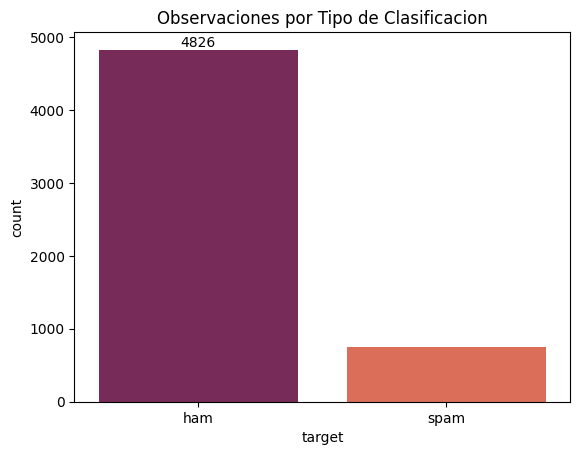

In [54]:
# Exploramos la ditribucion del dataset

# gráfico de recuento en una sola variable categórica
ax = sns.countplot(x = data['target'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observaciones por Tipo de Clasificacion")

# show plot
plt.show()

**División de datos**

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(data['text'],
                                                    data['objetivo'],
                                                    test_size=0.3,
                                                    random_state=0)

**Preparación y limpieza de datos**

In [56]:
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

In [57]:
#preprocessed data: Lemm + stopword removal
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]
#preprocessed_text_1[0:10]

#preprocessed data: Lemm + no stopword removal
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]
#preprocessed_text_2[0:10]

#preprocessed data: Stem + stopword removal
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]
#preprocessed_text_3[0:10]

#preprocessed data: Stem + no stopword removal
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]
#preprocessed_text_4[0:10]

In [58]:
def transform_model_data_w_count_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

In [59]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

In [60]:
#vectorize, model, and evaluate model using CountVectorizer

#Lemm + stopword removal
print("Lemm + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal
print("\nStem + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal
print("\nStem + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + CountVectorizer
Accuracy: 97.91 %
Balanced accuracy: 95.98 %
Precision: 92.86 %

Lemm + no stopword removal + CountVectorizer
Accuracy: 98.03 %
Balanced accuracy: 95.89 %
Precision: 93.95 %

Stem + stopword removal + CountVectorizer
Accuracy: 97.13 %
Balanced accuracy: 92.9 %
Precision: 93.56 %

Stem + no stopword removal + CountVectorizer
Accuracy: 97.73 %
Balanced accuracy: 94.56 %
Precision: 94.56 %


array([0, 0, 0, ..., 0, 0, 0])

In [61]:
#vectorize, model, and evaluate model using TfidfVectorizer

#Lemm + stopword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal
print("\nStem + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal
print("\nStem + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 97.61 %
Balanced accuracy: 93.18 %
Precision: 96.89 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 97.49 %
Balanced accuracy: 92.45 %
Precision: 97.72 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 95.69 %
Balanced accuracy: 86.48 %
Precision: 97.35 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 96.29 %
Balanced accuracy: 87.98 %
Precision: 98.96 %


array([0, 0, 0, ..., 0, 0, 0])

In [62]:
predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Accuracy: 96.29 %
Balanced accuracy: 87.98 %
Precision: 98.96 %
